In [21]:
import os
from dotenv import load_dotenv
import re
import math
from tqdm import tqdm
from huggingface_hub import login
import torch
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, set_seed, BitsAndBytesConfig
from datasets import load_dataset, Dataset, DatasetDict
import wandb
from peft import LoraConfig
from trl import SFTTrainer, SFTConfig
from datetime import datetime
import matplotlib.pyplot as plt
from peft import PeftModel
import torch.nn.functional as F

In [2]:
BASE_MODEL = "meta-llama/Meta-Llama-3.1-8B"
PROJECT_NAME = "pricer"
HF_USER = "Benny97"

# Data

DATASET_NAME = f"{HF_USER}/pricer-data"
MAX_SEQUENCE_LENGTH = 182
REVISION = None

# Run name for saving the model in the hub
RUN_NAME =  f"{datetime.now():%Y-%m-%d_%H.%M.%S}"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
HUB_MODEL_NAME = f"{HF_USER}/{PROJECT_RUN_NAME}"

# Hyperparameters for QLoRA

LORA_R = 32
LORA_ALPHA = 64
TARGET_MODULES = ["q_proj", "v_proj", "k_proj", "o_proj"]
LORA_DROPOUT = 0.1
QUANT_4_BIT = True

# Hyperparameters for Training

EPOCHS = 1 
BATCH_SIZE = 1
GRADIENT_ACCUMULATION_STEPS = 16
LEARNING_RATE = 1e-4
LR_SCHEDULER_TYPE = 'cosine'
WARMUP_RATIO = 0.03
OPTIMIZER = "paged_adamw_32bit"

# Admin config - note that SAVE_STEPS is how often it will upload to the hub

STEPS = 50
SAVE_STEPS = 2000
LOG_TO_WANDB = True

%matplotlib inline

In [3]:
HUB_MODEL_NAME

'Benny97/pricer-2025-05-08_23.00.31'

In [3]:
# Log in to HuggingFace
load_dotenv(override=True)
os.environ['HUGGINGFACE_RW_TOKEN'] = os.getenv('HUGGINGFACE_RW_TOKEN')
hf_token = os.environ['HUGGINGFACE_RW_TOKEN']
login(hf_token, add_to_git_credential=True)

In [4]:
# Log in to Weights & Biases
load_dotenv(override=True)
os.environ['WANDB_API_KEY'] = os.getenv('WANDB_API_KEY')
wandb.login()

# Configure Weights & Biases to record against our project
os.environ["WANDB_PROJECT"] = PROJECT_NAME
os.environ["WANDB_LOG_MODEL"] = "checkpoint" if LOG_TO_WANDB else "end"
os.environ["WANDB_WATCH"] = "gradients"

wandb: Currently logged in as: benny-guan97 (benny-guan97-iee) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [5]:
dataset = load_dataset(DATASET_NAME)
train = dataset['train'].shuffle(seed=42).select(range(16_000))
test = dataset['test']

In [7]:
if LOG_TO_WANDB:
  wandb.init(project=PROJECT_NAME, name=RUN_NAME)

In [6]:
if QUANT_4_BIT:
  quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
  )
else:
  quant_config = BitsAndBytesConfig(
    load_in_8bit=True,
    bnb_8bit_compute_dtype=torch.bfloat16
  )

In [7]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    quantization_config=quant_config,
    device_map='cuda',
    torch_dtype=torch.bfloat16
)
base_model.generation_config.pad_token_id = tokenizer.pad_token_id

print(f"Memory footprint: {base_model.get_memory_footprint() / 1e6:.1f} MB")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Memory footprint: 5591.5 MB


In [10]:
from trl import DataCollatorForCompletionOnlyLM
response_template = "Price is $"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

In [14]:
# First, specify the configuration parameters for LoRA

lora_parameters = LoraConfig(
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    r=LORA_R,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=TARGET_MODULES,
)

# Next, specify the general configuration parameters for training

train_parameters = SFTConfig(
    output_dir=PROJECT_RUN_NAME,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=1,
    eval_strategy="no",
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS,
    optim=OPTIMIZER,
    save_steps=SAVE_STEPS,
    save_total_limit=10,
    logging_steps=STEPS,
    learning_rate=LEARNING_RATE,
    weight_decay=0.001,
    fp16=False,
    bf16=True,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=WARMUP_RATIO,
    group_by_length=True,
    lr_scheduler_type=LR_SCHEDULER_TYPE,
    report_to="wandb" if LOG_TO_WANDB else None,
    run_name=RUN_NAME,
    max_seq_length=MAX_SEQUENCE_LENGTH,
    dataset_text_field="text",
    save_strategy="steps",
    hub_strategy="every_save",
    push_to_hub=True,
    hub_model_id=HUB_MODEL_NAME,
    hub_private_repo=True
)

# And now, the Supervised Fine Tuning Trainer will carry out the fine-tuning
# Given these 2 sets of configuration parameters
# The latest version of trl is showing a warning about labels - please ignore this warning
# But let me know if you don't see good training results (loss coming down).

fine_tuning = SFTTrainer(
    model=base_model,
    train_dataset=train,
    peft_config=lora_parameters,
    args=train_parameters,
    data_collator=collator
  )

C:\Users\benny\anaconda3\envs\llms\Lib\site-packages\peft\mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
C:\Users\benny\anaconda3\envs\llms\Lib\site-packages\peft\tuners\tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [12]:
# Fine-tune!
fine_tuning.train()

# Push fine-tuned model to Hugging Face
fine_tuning.model.push_to_hub(PROJECT_RUN_NAME, private=True)
print(f"Saved to the hub: {PROJECT_RUN_NAME}")

wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


Step,Training Loss
50,2.141600
100,1.895000
150,1.887400
200,1.881400
250,1.922200
300,1.874300
350,1.873200
400,1.847000
450,1.841900
500,1.868700


wandb: Adding directory to artifact (.\pricer-2025-05-08_23.00.31\checkpoint-1000)... Done. 0.5s
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


README.md:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

C:\Users\benny\anaconda3\envs\llms\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\benny\.cache\huggingface\hub\models--Benny97--pricer-2025-05-08_23.00.31. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Saved to the hub: pricer-2025-05-08_23.00.31


In [13]:
if LOG_TO_WANDB:
  wandb.finish()

train/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
train/global_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
train/grad_norm,▅▂▃▃▂▄▁▃▁█▅▄▄▁▃▆▇▄▂▂
train/learning_rate,███▇▇▇▆▆▅▅▄▄▃▃▂▂▁▁▁▁
train/loss,█▃▃▃▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁
train/mean_token_accuracy,▁▆▆▇▇▇█▇▇▆▇██▇▇▇█▇▇▇
train/num_tokens,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
total_flos,1.2921826442276045e+17
train/epoch,1
train/global_step,1000
train/grad_norm,1.47619


In [10]:

RUN_NAME = "2025-05-08_23.00.31"
PROJECT_RUN_NAME = f"{PROJECT_NAME}-{RUN_NAME}"
REVISION = None
FINETUNED_MODEL = f"{HF_USER}/{PROJECT_RUN_NAME}"

In [11]:
if REVISION:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL, revision=REVISION)
else:
  fine_tuned_model = PeftModel.from_pretrained(base_model, FINETUNED_MODEL)
print(f"Memory footprint: {fine_tuned_model.get_memory_footprint() / 1e6:.1f} MB")

Memory footprint: 5700.6 MB


In [12]:
fine_tuned_model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora

In [13]:
def extract_price(s):
    if "Price is $" in s:
      contents = s.split("Price is $")[1]
      contents = contents.replace(',','')
      match = re.search(r"[-+]?\d*\.\d+|\d+", contents)
      return float(match.group()) if match else 0
    return 0

In [14]:
# Original prediction function takes the most likely next token

def model_predict(prompt):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to("cuda")
    attention_mask = torch.ones(inputs.shape, device="cuda")
    outputs = fine_tuned_model.generate(inputs, attention_mask=attention_mask, max_new_tokens=3, num_return_sequences=1)
    response = tokenizer.decode(outputs[0])
    return extract_price(response)

In [19]:
# An improved prediction function takes a weighted average of the top 3 choices
top_K = 3

def improved_model_predict(prompt, device="cuda"):
    set_seed(42)
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
    attention_mask = torch.ones(inputs.shape, device=device)

    with torch.no_grad():
        outputs = fine_tuned_model(inputs, attention_mask=attention_mask)
        next_token_logits = outputs.logits[:, -1, :].to('cpu')

    next_token_probs = F.softmax(next_token_logits, dim=-1)
    top_prob, top_token_id = next_token_probs.topk(top_K)
    prices, weights = [], []
    for i in range(top_K):
      predicted_token = tokenizer.decode(top_token_id[0][i])
      probability = top_prob[0][i]
      try:
        result = float(predicted_token)
      except ValueError as e:
        result = 0.0
      if result > 0:
        prices.append(result)
        weights.append(probability)
    if not prices:
      return 0.0, 0.0
    total = sum(weights)
    weighted_prices = [price * weight / total for price, weight in zip(prices, weights)]
    return sum(weighted_prices).item()

In [30]:


# Used for writing to output in color

GREEN = "\033[92m"
YELLOW = "\033[93m"
RED = "\033[91m"
RESET = "\033[0m"
COLOR_MAP = {"red":RED, "orange": YELLOW, "green": GREEN}

%matplotlib inline

In [32]:
class Tester:

    def __init__(self, predictor, data, title=None, size=250):
        self.predictor = predictor
        self.data = data
        self.title = title or predictor.__name__.replace("_", " ").title()
        self.size = size
        self.guesses = []
        self.truths = []
        self.errors = []
        self.sles = []
        self.colors = []

    def color_for(self, error, truth):
        if error<40 or error/truth < 0.2:
            return "green"
        elif error<80 or error/truth < 0.4:
            return "orange"
        else:
            return "red"

    def run_datapoint(self, i):
        datapoint = self.data[i]
        guess = self.predictor(datapoint["text"])
        truth = datapoint["price"]
        error = abs(guess - truth)
        log_error = math.log(truth+1) - math.log(guess+1)
        sle = log_error ** 2
        color = self.color_for(error, truth)
        title = datapoint["text"].split("\n\n")[1][:20] + "..."
        self.guesses.append(guess)
        self.truths.append(truth)
        self.errors.append(error)
        self.sles.append(sle)
        self.colors.append(color)
        print(f"{COLOR_MAP[color]}{i+1}: Guess: ${guess:,.2f} Truth: ${truth:,.2f} Error: ${error:,.2f} SLE: {sle:,.2f} Item: {title}{RESET}")

    def chart(self, title):
        max_error = max(self.errors)
        plt.figure(figsize=(12, 8))
        max_val = max(max(self.truths), max(self.guesses))
        plt.plot([0, max_val], [0, max_val], color='deepskyblue', lw=2, alpha=0.6)
        plt.scatter(self.truths, self.guesses, s=3, c=self.colors)
        plt.xlabel('Ground Truth')
        plt.ylabel('Model Estimate')
        plt.xlim(0, max_val)
        plt.ylim(0, max_val)
        plt.title(title)
        plt.show()

    def report(self):
        average_error = sum(self.errors) / self.size
        rmsle = math.sqrt(sum(self.sles) / self.size)
        hits = sum(1 for color in self.colors if color=="green")
        title = f"{self.title} Error=${average_error:,.2f} RMSLE={rmsle:,.2f} Hits={hits/self.size*100:.1f}%"
        self.chart(title)

    def run(self):
        self.error = 0
        for i in range(self.size):
            self.run_datapoint(i)
        self.report()

    @classmethod
    def test(cls, function, data):
        cls(function, data).run()

1: Guess: $346.00 Truth: $374.41 Error: $28.41 SLE: 0.01 Item: OEM AC Compressor w/...
2: Guess: $141.00 Truth: $225.11 Error: $84.11 SLE: 0.22 Item: Motorcraft YB3125 Fa...
3: Guess: $37.50 Truth: $61.68 Error: $24.18 SLE: 0.24 Item: Dorman Front Washer ...
4: Guess: $592.00 Truth: $599.99 Error: $7.99 SLE: 0.00 Item: HP Premium HD Plus T...
5: Guess: $29.50 Truth: $16.99 Error: $12.51 SLE: 0.28 Item: Super Switch Pickup ...
6: Guess: $14.25 Truth: $31.99 Error: $17.74 SLE: 0.60 Item: Horror Bookmarks, Re...
7: Guess: $124.00 Truth: $101.79 Error: $22.21 SLE: 0.04 Item: SK6241 - Stinger 4 G...
8: Guess: $284.00 Truth: $289.00 Error: $5.00 SLE: 0.00 Item: Godox ML60Bi LED Lig...
9: Guess: $860.00 Truth: $635.86 Error: $224.14 SLE: 0.09 Item: Randall G3 Plus Comb...
10: Guess: $60.00 Truth: $65.99 Error: $5.99 SLE: 0.01 Item: HOLDWILL 6 Pack LED ...
11: Guess: $296.00 Truth: $254.21 Error: $41.79 SLE: 0.02 Item: Viking Horns 3 Gallo...
12: Guess: $298.00 Truth: $412.99 Error: $114.99 SL

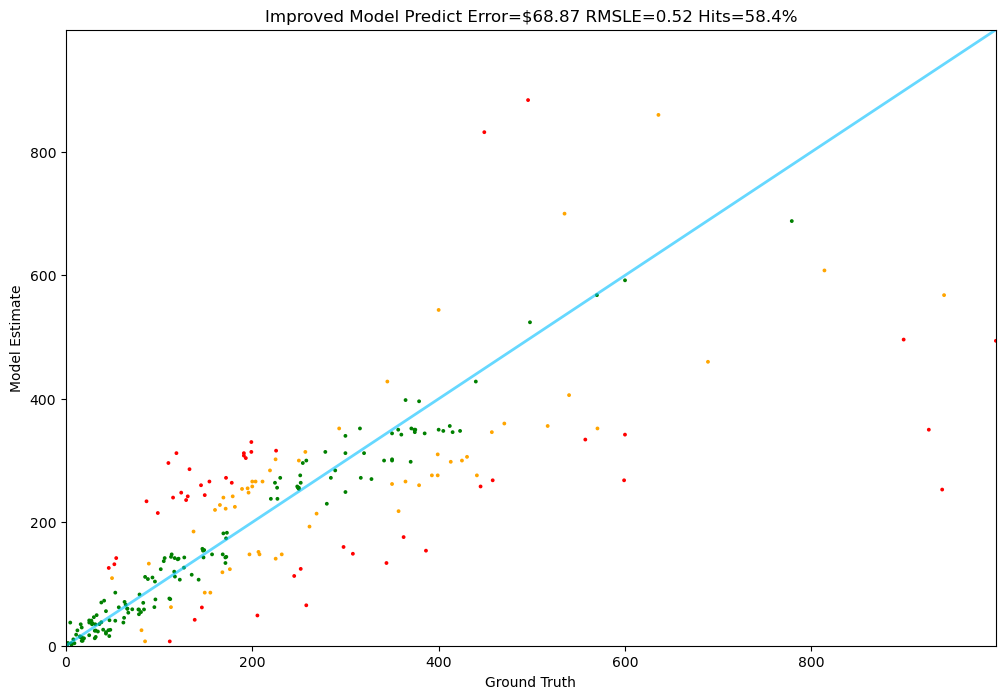

In [36]:
Tester.test(improved_model_predict, test)